In [1]:
# -*-coding=utf-8 -*-
from __future__ import print_function
import pandas as pd
import numpy as np
from feature import Feature
from model import XGB
from sklearn.metrics import f1_score

In [2]:
data = pd.read_csv('data/seg_Ax.txt', sep='\t', header=None, names=['seg_Ax'], encoding='utf-8', dtype=str)
data['seg_Bx'] = pd.read_csv('data/seg_Bx.txt', header=None, encoding='utf-8', dtype=str)
data['label'] = pd.read_csv('data/label.txt',header=None)
print(data)

                                                   seg_Ax  \
0                                           怎么 更改 花呗 手机号码   
1                               也 开 不了 花呗 ， 就 这样 了 ？ 完事 了   
2                                       花呗 冻结 以后 还 能 开通 吗   
3                                             如何 得知 关闭 借呗   
4                                                花呗 扫码 付钱   
5                                         花呗 逾期 后 不能 分期 吗   
6                                                花呗 分期 清空   
7                                             借呗 逾期 短信 通知   
8                              借呗 即将 到期 要 还 的 账单 还 能 分期 吗   
9                                      花呗 为什么 不能 支付 手机 交易   
10                                 在 吗 ， 双 * 有 临时 花呗 额度 吗   
11                                        我 什么 时候 开通 了 花呗   
12                   花呗 每月 还 了 最低 还款 后 还 会 有 万分之 五 的 利息 吗   
13                                     我 想 用 蚂蚁借呗 怎么 用 不了   
14                                            花呗 也 不能 用 了   
15                      

In [3]:
fea = Feature(data,tr=False)
fea.load()
print(fea.features)

        label       lda_sim   lsa_sim    ed   1-share   2-share  \
0         1.0  7.843739e-02  0.480636  19.0  0.285714  0.285714   
1         0.0  9.293608e-01  0.603552  12.0  0.235294  0.235294   
2         0.0  5.224520e-01  0.547150  10.0  0.400000  0.400000   
3         0.0  4.551527e-01  0.255402   6.0  0.571429  0.571429   
4         0.0  3.681470e-01  0.616340   7.0  0.222222  0.222222   
5         0.0  1.836340e-01  0.552836  11.0  0.473684  0.473684   
6         0.0  2.404350e-01  0.183290   3.0  0.666667  0.666667   
7         0.0  4.018385e-01  0.553626   7.0  0.444444  0.444444   
8         0.0  3.777785e-01  0.293186   7.0  0.611111  0.611111   
9         0.0  6.929956e-01  0.634496  10.0  0.266667  0.266667   
10        0.0  1.457196e-01  0.225276  10.0  0.375000  0.375000   
11        0.0  3.497718e-01  0.135114   4.0  0.615385  0.615385   
12        0.0  5.892405e-01  0.401048  12.0  0.272727  0.272727   
13        0.0  3.784013e-01  0.651431  18.0  0.300000  0.30000

# 开始调参

In [4]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn import preprocessing
import crash_on_ipy
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
train = fea.features
target = 'label'

In [6]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    best_n_estimators = 100
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, as_pandas=True)
        # print(cvresult)
        # print(cvresult.shape)
        alg.set_params(n_estimators=cvresult.shape[0])
        best_n_estimators = cvresult.shape[0]

    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'], eval_metric='auc')

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

    # Print model report:
    print("\nModel Report")
    print("Best n_estimators : %d" % best_n_estimators)
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions)) 
    print("F1 : %.4g" % metrics.f1_score(dtrain['label'].values, dtrain_predictions)) 
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob)) 

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig(fname = 'feature_weights.png')
    plt.show()
    # plt.close()

    return best_n_estimators

In [7]:
def print_cv_res(gsearch):
    print('-'*20+'gird_scores_:'+'-'*20)
    for grid_score in gsearch.grid_scores_:
        print(grid_score)
    print('-'*20+'best_params_, best_score_:'+'-'*20)
    print(gsearch.best_params_, gsearch.best_score_)

In [8]:
# predictors means features
predictors = [x for x in train.columns if x not in [target]]

# 后边的实验，运行完GridSearchCV会使下一次运行GridSearchCV运行时冻结cpu。必须重启Kernel才能再次运行GridSearchCV（不知道原因）

# 先尝试找一个n_estimators

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Best n_estimators : 79
Accuracy : 0.5964
F1 : 0.3975
AUC Score (Train): 0.716251


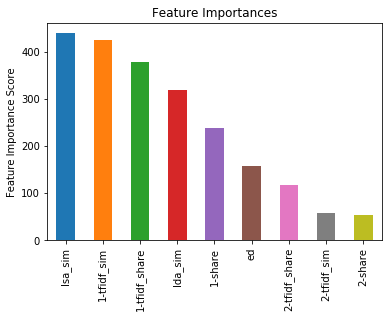

In [9]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=3,
 scale_pos_weight=5.48,
 max_delta_step=0.5,
 seed=27)
# Tune n_estimators
n_estimators1 = modelfit(xgb1, train, predictors)

# 0. 调节 scale_pos_weight 与 max_delta_step

In [10]:
n_estimators1 = 79

param_test0 = {
 'max_delta_step': [0.1, 0.3, 0.5, 0.7],
 'scale_pos_weight': [1/0.1823-1, 1/0.1823, 1/0.1823+1]
}
gsearch0 = GridSearchCV(estimator = 
                        XGBClassifier( 
                            learning_rate =0.1, 
                            n_estimators=n_estimators1, 
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0.4,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            objective= 'binary:logistic',
                            nthread=3,
                            seed=27),
 param_grid = param_test0, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
print('Tuning result for max_delta_step and scale_pos_weight:')
print_cv_res(gsearch0)
max_delta_step0 = gsearch0.best_params_['max_delta_step']
scale_pos_weight0 = gsearch0.best_params_['scale_pos_weight']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Tuning result for max_delta_step and scale_pos_weight:
--------------------gird_scores_:--------------------
mean: 0.39616, std: 0.00695, params: {'scale_pos_weight': 4.485463521667581, 'max_delta_step': 0.1}
mean: 0.38534, std: 0.00428, params: {'scale_pos_weight': 5.485463521667581, 'max_delta_step': 0.1}
mean: 0.37228, std: 0.00107, params: {'scale_pos_weight': 6.485463521667581, 'max_delta_step': 0.1}
mean: 0.39636, std: 0.00598, params: {'scale_pos_weight': 4.485463521667581, 'max_delta_step': 0.3}
mean: 0.38676, std: 0.00350, params: {'scale_pos_weight': 5.485463521667581, 'max_delta_step': 0.3}
mean: 0.37616, std: 0.00137, params: {'scale_pos_weight': 6.485463521667581, 'max_delta_step': 0.3}
mean: 0.39761, std: 0.00694, params: {'scale_pos_weight': 4.485463521667581, 'max_delta_step': 0.5}
mean: 0.38740, std: 0.00276, params: {'scale_pos_weight': 5.485463521667581, 'max_delta_step': 0.5}
mean: 0.37634, std: 0.00189, params: {'scale_pos_weight': 6.485463521667581, 'max_delta_ste

# 0b. 继续调节 scale_pos_weight 与 max_delta_step

In [9]:
n_estimators1 = 79

param_test0b = {
 'max_delta_step': [0.7, 1, 5 ,10],
 'scale_pos_weight': [0.5 ,1, 2, 1/0.1823-1]
}
gsearch0b = GridSearchCV(estimator = 
                        XGBClassifier( 
                            learning_rate =0.1, 
                            n_estimators=n_estimators1, 
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0.4,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            objective= 'binary:logistic',
                            nthread=3,
                            seed=27),
 param_grid = param_test0b, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch0b.fit(train[predictors],train[target])
print('Tuning result for max_delta_step and scale_pos_weight:')
print_cv_res(gsearch0b)
max_delta_step0b = gsearch0b.best_params_['max_delta_step']
scale_pos_weight0b = gsearch0b.best_params_['scale_pos_weight']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Tuning result for max_delta_step and scale_pos_weight:
--------------------gird_scores_:--------------------
mean: 0.04680, std: 0.00509, params: {'scale_pos_weight': 0.5, 'max_delta_step': 0.7}
mean: 0.15149, std: 0.00404, params: {'scale_pos_weight': 1, 'max_delta_step': 0.7}
mean: 0.32132, std: 0.00563, params: {'scale_pos_weight': 2, 'max_delta_step': 0.7}
mean: 0.39765, std: 0.00744, params: {'scale_pos_weight': 4.485463521667581, 'max_delta_step': 0.7}
mean: 0.04447, std: 0.00349, params: {'scale_pos_weight': 0.5, 'max_delta_step': 1}
mean: 0.14955, std: 0.00654, params: {'scale_pos_weight': 1, 'max_delta_step': 1}
mean: 0.32114, std: 0.00670, params: {'scale_pos_weight': 2, 'max_delta_step': 1}
mean: 0.39756, std: 0.00765, params: {'scale_pos_weight': 4.485463521667581, 'max_delta_step': 1}
mean: 0.04560, std: 0.00433, params: {'scale_pos_weight': 0.5, 'max_delta_step': 5}
mean: 0.14598, std: 0.00540, params: {'scale_pos_weight': 1, 'max_delta_step': 5}
mean: 0.32011, std: 0.006

# 0c. 继续调节 scale_pos_weight 与 max_delta_step

In [9]:
n_estimators1 = 79

param_test0c = {
 'max_delta_step': [0.65, 0.7, 0.75],
 'scale_pos_weight': [1/0.1823-1-0.5, 1/0.1823-1, 1/0.1823-1+0.5]
}
gsearch0c = GridSearchCV(estimator = 
                        XGBClassifier( 
                            learning_rate =0.1, 
                            n_estimators=n_estimators1, 
                            max_depth=5,
                            min_child_weight=1,
                            gamma=0.4,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            objective= 'binary:logistic',
                            nthread=3,
                            seed=27),
 param_grid = param_test0c, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch0c.fit(train[predictors],train[target])
print('Tuning result for max_delta_step and scale_pos_weight:')
print_cv_res(gsearch0c)
max_delta_step0c = gsearch0c.best_params_['max_delta_step']
scale_pos_weight0c = gsearch0c.best_params_['scale_pos_weight']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Tuning result for max_delta_step and scale_pos_weight:
--------------------gird_scores_:--------------------
mean: 0.39884, std: 0.00849, params: {'scale_pos_weight': 3.9854635216675813, 'max_delta_step': 0.65}
mean: 0.39680, std: 0.00691, params: {'scale_pos_weight': 4.485463521667581, 'max_delta_step': 0.65}
mean: 0.39316, std: 0.00501, params: {'scale_pos_weight': 4.985463521667581, 'max_delta_step': 0.65}
mean: 0.39880, std: 0.00775, params: {'scale_pos_weight': 3.9854635216675813, 'max_delta_step': 0.7}
mean: 0.39765, std: 0.00744, params: {'scale_pos_weight': 4.485463521667581, 'max_delta_step': 0.7}
mean: 0.39325, std: 0.00565, params: {'scale_pos_weight': 4.985463521667581, 'max_delta_step': 0.7}
mean: 0.39882, std: 0.00778, params: {'scale_pos_weight': 3.9854635216675813, 'max_delta_step': 0.75}
mean: 0.39714, std: 0.00669, params: {'scale_pos_weight': 4.485463521667581, 'max_delta_step': 0.75}
mean: 0.39270, std: 0.00623, params: {'scale_pos_weight': 4.985463521667581, 'max_d

# 1. 使用宽范围调节 max_depth 与 min_child_weight

In [9]:
n_estimators1 = 79
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65

param_test1 = {
 'max_depth':range(1,8,2),
 'min_child_weight':range(0,3,1)
}
gsearch1 = GridSearchCV(estimator =
                        XGBClassifier(learning_rate =0.1, 
                                      n_estimators=n_estimators1,
                                      gamma=0.4,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      objective= 'binary:logistic',
                                      nthread=3,
                                      scale_pos_weight=scale_pos_weight0c,
                                      max_delta_step=max_delta_step0c,
                                      seed=27),
 param_grid = param_test1, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
print('Wide range tuning result for max_depth and min_child_weight:')
print_cv_res(gsearch1)

max_depth1 = gsearch1.best_params_['max_depth']
min_child_weight1 = gsearch1.best_params_['min_child_weight']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Wide range tuning result for max_depth and min_child_weight:
--------------------gird_scores_:--------------------
mean: 0.39061, std: 0.00793, params: {'max_depth': 1, 'min_child_weight': 0}
mean: 0.39061, std: 0.00793, params: {'max_depth': 1, 'min_child_weight': 1}
mean: 0.39061, std: 0.00793, params: {'max_depth': 1, 'min_child_weight': 2}
mean: 0.39845, std: 0.00730, params: {'max_depth': 3, 'min_child_weight': 0}
mean: 0.39835, std: 0.00714, params: {'max_depth': 3, 'min_child_weight': 1}
mean: 0.39772, std: 0.00819, params: {'max_depth': 3, 'min_child_weight': 2}
mean: 0.39740, std: 0.00870, params: {'max_depth': 5, 'min_child_weight': 0}
mean: 0.39775, std: 0.00882, params: {'max_depth': 5, 'min_child_weight': 1}
mean: 0.39866, std: 0.00795, params: {'max_depth': 5, 'min_child_weight': 2}
mean: 0.39700, std: 0.00788, params: {'max_depth': 7, 'min_child_weight': 0}
mean: 0.39710, std: 0.00862, params: {'max_depth': 7, 'min_child_weight': 1}
mean: 0.39628, std: 0.00753, params: {

# 2. 使用小范围调节 max_depth 与 min_child_weight

In [10]:
n_estimators1 = 79
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth1 = 5
min_child_weight1 = 2

param_test2 = {
 'max_depth': [max_depth1-1, max_depth1, max_depth1+1],
 'min_child_weight': [min_child_weight1-0.5,min_child_weight1,
                     min_child_weight1+0.5]
}
gsearch2 = GridSearchCV(estimator =
                        XGBClassifier(learning_rate =0.1, 
                                      n_estimators=n_estimators1,
                                      gamma=0.4,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      objective= 'binary:logistic',
                                      nthread=3,
                                      scale_pos_weight=scale_pos_weight0c,
                                      max_delta_step=max_delta_step0c,
                                      seed=27),
 param_grid = param_test2, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
print('Wide range tuning result for max_depth and min_child_weight:')
print_cv_res(gsearch2)

max_depth2 = gsearch2.best_params_['max_depth']
min_child_weight2 = gsearch2.best_params_['min_child_weight']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Wide range tuning result for max_depth and min_child_weight:
--------------------gird_scores_:--------------------
mean: 0.39747, std: 0.00831, params: {'max_depth': 4, 'min_child_weight': 1.5}
mean: 0.39791, std: 0.00807, params: {'max_depth': 4, 'min_child_weight': 2}
mean: 0.39770, std: 0.00790, params: {'max_depth': 4, 'min_child_weight': 2.5}
mean: 0.39801, std: 0.00886, params: {'max_depth': 5, 'min_child_weight': 1.5}
mean: 0.39866, std: 0.00795, params: {'max_depth': 5, 'min_child_weight': 2}
mean: 0.39819, std: 0.00778, params: {'max_depth': 5, 'min_child_weight': 2.5}
mean: 0.39743, std: 0.00916, params: {'max_depth': 6, 'min_child_weight': 1.5}
mean: 0.39645, std: 0.00815, params: {'max_depth': 6, 'min_child_weight': 2}
mean: 0.39647, std: 0.00881, params: {'max_depth': 6, 'min_child_weight': 2.5}
--------------------best_params_, best_score_:--------------------
{'max_depth': 5, 'min_child_weight': 2} 0.39866410892


# 2b. 使用更大的值调节 min_child_weight

In [9]:
n_estimators1 = 79
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth2 = 5
min_child_weight2 = 2

param_test2b = {
 'min_child_weight': [min_child_weight2, min_child_weight2+2,
                     min_child_weight2+4, min_child_weight2+6]
}
gsearch2b = GridSearchCV(estimator =
                        XGBClassifier(learning_rate =0.1, 
                                      n_estimators=n_estimators1,
                                      max_depth=max_depth2,
                                      gamma=0.4,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      objective= 'binary:logistic',
                                      nthread=3,
                                      scale_pos_weight=scale_pos_weight0c,
                                      max_delta_step=max_delta_step0c,
                                      seed=27),
 param_grid = param_test2b, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])
print('Wide range tuning result for max_depth and min_child_weight:')
print_cv_res(gsearch2b)

min_child_weight2b = gsearch2b.best_params_['min_child_weight']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Wide range tuning result for max_depth and min_child_weight:
--------------------gird_scores_:--------------------
mean: 0.39866, std: 0.00795, params: {'min_child_weight': 2}
mean: 0.39803, std: 0.00780, params: {'min_child_weight': 4}
mean: 0.39856, std: 0.00847, params: {'min_child_weight': 6}
mean: 0.39805, std: 0.00876, params: {'min_child_weight': 8}
--------------------best_params_, best_score_:--------------------
{'min_child_weight': 2} 0.39866410892


# 3. 调节 gamma

In [9]:
n_estimators1 = 79
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth2 = 5
min_child_weight2b = 2

param_test3 = {
 'gamma': [i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator =
                        XGBClassifier(learning_rate =0.1, 
                                      n_estimators=n_estimators1,
                                      max_depth=max_depth2,
                                      min_child_weight=min_child_weight2b,
                                      subsample=0.8,
                                      colsample_bytree=0.8,
                                      objective= 'binary:logistic',
                                      nthread=3,
                                      scale_pos_weight=scale_pos_weight0c,
                                      max_delta_step=max_delta_step0c,
                                      seed=27),
 param_grid = param_test3, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
print('Tuning result for gamma:')
print_cv_res(gsearch3)
gamma3 = gsearch3.best_params_['gamma']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Tuning result for gamma:
--------------------gird_scores_:--------------------
mean: 0.39872, std: 0.00815, params: {'gamma': 0.0}
mean: 0.39857, std: 0.00809, params: {'gamma': 0.1}
mean: 0.39901, std: 0.00795, params: {'gamma': 0.2}
mean: 0.39881, std: 0.00795, params: {'gamma': 0.3}
mean: 0.39866, std: 0.00795, params: {'gamma': 0.4}
mean: 0.39801, std: 0.00760, params: {'gamma': 0.5}
mean: 0.39841, std: 0.00747, params: {'gamma': 0.6}
mean: 0.39827, std: 0.00841, params: {'gamma': 0.7}
mean: 0.39862, std: 0.00757, params: {'gamma': 0.8}
mean: 0.39819, std: 0.00721, params: {'gamma': 0.9}
--------------------best_params_, best_score_:--------------------
{'gamma': 0.2} 0.399014839312


# 重新矫正 n_estimators

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Best n_estimators : 64
Accuracy : 0.7111
F1 : 0.412
AUC Score (Train): 0.715718


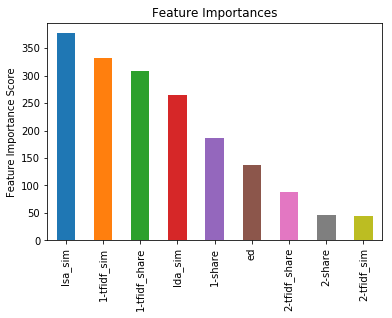

In [10]:
n_estimators1 = 79
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth2 = 5
min_child_weight2b = 2
gamma3 = 0.2

xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=max_depth2,
 min_child_weight=min_child_weight2b,
 gamma=gamma3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=3,
 scale_pos_weight=scale_pos_weight0c,
 max_delta_step=max_delta_step0c,
 seed=27)
n_estimators2 = modelfit(xgb2, train, predictors)

# 4. 调节 subsample 与 colsample_bytree

In [9]:
n_estimators2 = 64
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth2 = 5
min_child_weight2b = 2
gamma3 = 0.2

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator =
                        XGBClassifier(learning_rate =0.1, 
                          n_estimators=n_estimators2,
                          max_depth=max_depth2,
                          min_child_weight=min_child_weight2b,
                          gamma=gamma3,
                          objective= 'binary:logistic',
                          nthread=3,
                          scale_pos_weight=scale_pos_weight0c,
                          max_delta_step=max_delta_step0c,
                          seed=27),
 param_grid = param_test4, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
print('Tuning result for subsample and colsample_bytree:')
print_cv_res(gsearch4)
subsample4 = gsearch4.best_params_['subsample']
colsample_bytree4 = gsearch4.best_params_['colsample_bytree']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Tuning result for subsample and colsample_bytree:
--------------------gird_scores_:--------------------
mean: 0.39763, std: 0.00704, params: {'subsample': 0.6, 'colsample_bytree': 0.6}
mean: 0.39810, std: 0.00869, params: {'subsample': 0.7, 'colsample_bytree': 0.6}
mean: 0.39790, std: 0.00858, params: {'subsample': 0.8, 'colsample_bytree': 0.6}
mean: 0.39786, std: 0.00685, params: {'subsample': 0.9, 'colsample_bytree': 0.6}
mean: 0.39789, std: 0.00621, params: {'subsample': 0.6, 'colsample_bytree': 0.7}
mean: 0.39757, std: 0.00826, params: {'subsample': 0.7, 'colsample_bytree': 0.7}
mean: 0.39811, std: 0.00753, params: {'subsample': 0.8, 'colsample_bytree': 0.7}
mean: 0.39902, std: 0.00746, params: {'subsample': 0.9, 'colsample_bytree': 0.7}
mean: 0.39663, std: 0.00824, params: {'subsample': 0.6, 'colsample_bytree': 0.8}
mean: 0.39769, std: 0.00729, params: {'subsample': 0.7, 'colsample_bytree': 0.8}
mean: 0.39862, std: 0.00891, params: {'subsample': 0.8, 'colsample_bytree': 0.8}
mean:

# 5. 精调 subsample 与 colsample_bytree

In [9]:
n_estimators2 = 64
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth2 = 5
min_child_weight2b = 2
gamma3 = 0.2
subsample4 = 0.9
colsample_bytree4 = 0.7

param_test5 = {
 'subsample':[subsample4-5.0/100, subsample4, subsample4+5.0/100, subsample4+5.0/100*2],
 'colsample_bytree':[colsample_bytree4-5.0/100, colsample_bytree4, colsample_bytree4+5.0/100,
                     colsample_bytree4+5.0/100*2]
}

gsearch5 = GridSearchCV(estimator =
                        XGBClassifier(learning_rate =0.1, 
                          n_estimators=n_estimators2,
                          max_depth=max_depth2,
                          min_child_weight=min_child_weight2b,
                          gamma=gamma3,
                          objective= 'binary:logistic',
                          nthread=3,
                          scale_pos_weight=scale_pos_weight0c,
                          max_delta_step=max_delta_step0c,
                          seed=27),
 param_grid = param_test5, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
print('Finely tuning result for subsample and colsample_bytree:')
print_cv_res(gsearch5)
subsample5 = gsearch5.best_params_['subsample']
colsample_bytree5 = gsearch5.best_params_['colsample_bytree']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Finely tuning result for subsample and colsample_bytree:
--------------------gird_scores_:--------------------
mean: 0.39810, std: 0.00771, params: {'subsample': 0.85, 'colsample_bytree': 0.6499999999999999}
mean: 0.39786, std: 0.00685, params: {'subsample': 0.9, 'colsample_bytree': 0.6499999999999999}
mean: 0.39767, std: 0.00765, params: {'subsample': 0.9500000000000001, 'colsample_bytree': 0.6499999999999999}
mean: 0.39828, std: 0.00766, params: {'subsample': 1.0, 'colsample_bytree': 0.6499999999999999}
mean: 0.39821, std: 0.00842, params: {'subsample': 0.85, 'colsample_bytree': 0.7}
mean: 0.39902, std: 0.00746, params: {'subsample': 0.9, 'colsample_bytree': 0.7}
mean: 0.39767, std: 0.00896, params: {'subsample': 0.9500000000000001, 'colsample_bytree': 0.7}
mean: 0.39736, std: 0.00885, params: {'subsample': 1.0, 'colsample_bytree': 0.7}
mean: 0.39821, std: 0.00842, params: {'subsample': 0.85, 'colsample_bytree': 0.75}
mean: 0.39902, std: 0.00746, params: {'subsample': 0.9, 'colsample

# 6. 调节正则化系数

In [9]:
n_estimators2 = 64
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth2 = 5
min_child_weight2b = 2
gamma3 = 0.2
subsample5 = 0.9
colsample_bytree5 = 0.7

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 # 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator =
                        XGBClassifier(learning_rate =0.1, 
                          n_estimators=n_estimators2,
                          max_depth=max_depth2,
                          min_child_weight=min_child_weight2b,
                          gamma=gamma3,
                          objective= 'binary:logistic',
                          nthread=3,
                          scale_pos_weight=scale_pos_weight0c,
                          max_delta_step=max_delta_step0c,
                          subsample=subsample5,
                          colsample_bytree=colsample_bytree5,         
                          seed=27),
 param_grid = param_test6, scoring='f1',n_jobs=3,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
print('Tuning result for reg_alpha:')
print_cv_res(gsearch6)
reg_alpha6 = gsearch6.best_params_['reg_alpha']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Tuning result for reg_alpha:
--------------------gird_scores_:--------------------
mean: 0.39902, std: 0.00746, params: {'reg_alpha': 1e-05}
mean: 0.39871, std: 0.00803, params: {'reg_alpha': 0.01}
mean: 0.39756, std: 0.00804, params: {'reg_alpha': 0.1}
mean: 0.39814, std: 0.00841, params: {'reg_alpha': 1}
mean: 0.39771, std: 0.00807, params: {'reg_alpha': 100}
--------------------best_params_, best_score_:--------------------
{'reg_alpha': 1e-05} 0.399018549482


# 7. 细调 reg_alpha

In [9]:
n_estimators2 = 64
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth2 = 5
min_child_weight2b = 2
gamma3 = 0.2
subsample5 = 0.9
colsample_bytree5 = 0.7
reg_alpha6 = 1e-5

param_test7 = {
 'reg_alpha':[0, reg_alpha6/10, reg_alpha6/2, reg_alpha6*5]
}
gsearch7 = GridSearchCV(estimator =
                        XGBClassifier(learning_rate =0.1, 
                          n_estimators=n_estimators2,
                          max_depth=max_depth2,
                          min_child_weight=min_child_weight2b,
                          gamma=gamma3,
                          objective= 'binary:logistic',
                          nthread=3,
                          scale_pos_weight=scale_pos_weight0c,
                          max_delta_step=max_delta_step0c,
                          subsample=subsample5,
                          colsample_bytree=colsample_bytree5,
                          seed=27),
 param_grid = param_test7, scoring='f1',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
print('Finely tuning result for reg_alpha:')
print_cv_res(gsearch7)
reg_alpha7 = gsearch7.best_params_['reg_alpha']

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning

Finely tuning result for reg_alpha:
--------------------gird_scores_:--------------------
mean: 0.39902, std: 0.00746, params: {'reg_alpha': 0}
mean: 0.39902, std: 0.00746, params: {'reg_alpha': 1.0000000000000002e-06}
mean: 0.39902, std: 0.00746, params: {'reg_alpha': 5e-06}
mean: 0.39902, std: 0.00746, params: {'reg_alpha': 5e-05}
--------------------best_params_, best_score_:--------------------
{'reg_alpha': 0} 0.399018549482


# 重新校对 n_estimators

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Best n_estimators : 98
Accuracy : 0.714
F1 : 0.4169
AUC Score (Train): 0.720781


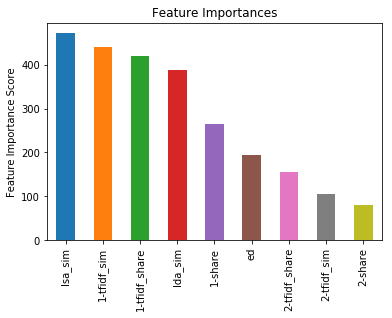

In [10]:
n_estimators2 = 64
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth2 = 5
min_child_weight2b = 2
gamma3 = 0.2
subsample5 = 0.9
colsample_bytree5 = 0.7
reg_alpha7 = 0

xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=max_depth2,
 min_child_weight=min_child_weight2b,
 gamma=gamma3,
 subsample=subsample5,
 colsample_bytree=colsample_bytree5,
 reg_alpha=reg_alpha7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=scale_pos_weight0c,
 max_delta_step=max_delta_step0c,
 seed=27)
n_estimators3 = modelfit(xgb3, train, predictors)


# 减小 learning_rate

/Users/marc/.pyenv/versions/atec/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Best n_estimators : 867
Accuracy : 0.7143
F1 : 0.4157
AUC Score (Train): 0.720494


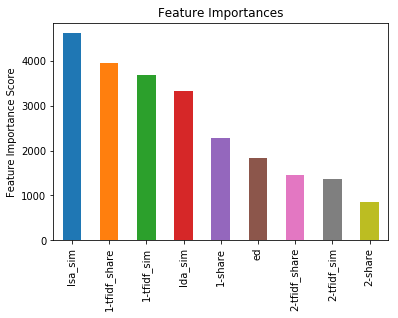

In [14]:
n_estimators3 = 98
scale_pos_weight0c = 3.99
max_delta_step0c = 0.65
max_depth2 = 5
min_child_weight2b = 2
gamma3 = 0.2
subsample5 = 0.9
colsample_bytree5 = 0.7
reg_alpha7 = 0

xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=max_depth2,
 min_child_weight=min_child_weight2b,
 gamma=gamma3,
 subsample=subsample5,
 colsample_bytree=colsample_bytree5,
 reg_alpha=reg_alpha7,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=scale_pos_weight0c,
 max_delta_step=max_delta_step0c,
 seed=27)
n_estimators4 = modelfit(xgb4, train, predictors)

In [16]:
print('Best params:')
params={
'n_estimators' : n_estimators4,
'learning_rate' : 0.01,
'scale_pos_weight' : scale_pos_weight0c,
'max_delta_step' : max_delta_step0c,
'max_depth' : max_depth2,
'min_child_weight' : min_child_weight2b,
'gamma' : gamma3,
'subsample' : subsample5,
'colsample_bytree5' : colsample_bytree5,
'reg_alpha' : reg_alpha7
}
print(params)

Best params:
{'n_estimators': 867, 'subsample': 0.9, 'reg_alpha': 0, 'gamma': 0.2, 'scale_pos_weight': 3.99, 'learning_rate': 0.01, 'colsample_bytree5': 0.7, 'max_delta_step': 0.65, 'max_depth': 5, 'min_child_weight': 2}
